Tutorial 1: Non-linear Search
=============================

__Lens Modeling__

In chapter 1, we learned how to use **PyAutoLens** to do many things: create galaxies, ray-trace light, simulate and fit
data. However, we did not learn how to answer the core questions that any scientist, when faced with observations of a
strong lens, seeks to answer:

 What lens galaxy mass distribution(s) and source galaxy light distribution(s) are responsible for the strong lens
 data I have observed? How can I explain the true deflection of light in this data, that is actually occuring in the
 real Universe? What does this tell me about galaxy structure and Cosmology?

To answer questions like this, and therefore use **PyAutoLens** to actually learn about the Universe, we need to
perform 'lens modeling', the topic of this chapter of the **HowToLens** lectures.

In this tutorial, we are going to load imaging data of strong lens and determine the light and mass profiles that best
represent the observed lensed source's light. That is, we are going to find the 'lens model' that best fits the data,
without any prior knowledge of what the `correct` model is.

To begin, we have to choose the parametrization of our lens model. We don't need to specify the values of its light
and mass profiles (e.g. the centre, intensity, einstein_radius, etc.), only the profiles themselves. In this example,
we use the following lens model:

 1) A Spherical Isothermal Sphere (SIS) mass profile via the `SphIsothermal` profile for the lens galaxy's mass.
 2) A Spherical Exponential light profile via the SphExponential` for the source-galaxy's light.

This is a very simple model, with very few parameters, so its a great starting point for us to learn how to perform
lens modeling!

__Non Linear Search__

So, how do we infer the parameters of our light and mass profiles above that give a good fit to our data?

Well, with the tools that we learned in chapter 1, we could try the following:

 1) Randomly guess a lens model, corresponding to some random set of parameters.
 2) Use this lens model to create a `Tracer` and fit the `Imaging` with it, via a `FitImaging` object.
 3) Quantify the goodness of fit using the log likelihood.
 4) Keep guessing lens models, repeating steps 1-3, until we eventually find a model that provides a good fit (i.e.
 a high value log likelihood)!

It may sound surprising, but this is actually the basis of how lens modeling works. However, we can do a lot better
than random guessing. Instead, we we can track the log likelihoods of all of our previous guesses, and guess more
models using the combinations of light and mass profile parameters that gave high log likelihood solutions previously.

The idea is that if a set of parameters provided a good fit to the data, another set of parameters with similar values
probably will too. Furthermore, if by following this approach we are able to keep guessing models with higher and higher
likelihoods, we should eventually 'climb' our way to the model with the highest likelihood overall!

This approach to model-fitting is called a `non-linear search` and it is a common algorithm applied by scientists to
many different problems. Over the next few tutorials, we are going to really get our heads around the concept of a
non-linear search; intuition which will prove crucial for us to become a successful lens modeler.

An animation of a non-linear search fitting a lens model is shown below. Note how the initial models that it fits give
a poor fit to the data, but that they gradually improve as more iterations are performed as the search begins to only
guess models that are near other, high likelihood, models.

![Lens Modeling Animation](https://github.com/Jammy2211/auto_files/blob/main/lensmodel.gif?raw=true "model")

**Credit: Amy Etherington**

In this tutorial, and throughout this enture chapter, we are going to use the non-linear search
called `dynesty` (https://github.com/joshspeagle/dynesty_. After many years of lens modeling, I have found this to be
the most effective non-linear search there is for lens modeling, albeit alternatives are available in **PyAutoLens**
and will be discussed later in this chapter.

For now, lets not worry about the details of how dynesty actually works and simply keep in our minds the described of
a non-linear search provided above.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__PyAutoFit__

Lens modeling with **PyAutoLens** uses the probabilistic programming language
[PyAutoFit](https://github.com/rhayes777/PyAutoFit), an open-source project that allows complex model
fitting techniques to be straightforwardly integrated into scientific modeling software. 

**PyAutoFit** is actually a spin-off project of **PyAutoLens**. whereby we found that the statistic techniques and
methods we applied to model strong lenses could be used in a more general setting to many different scientrific 
problems. Check it out if you are interested in developing your own software to perform advanced model-fitting!

We import this library separately from **PyAutoLens**.

In [2]:
import autofit as af

__Initial Setup__

Lets first load the `Imaging` dataset we'll fit a lens model with using a non-linear search. 

If you are interested in how we simulate the strong lens data, checkout the scripts in the 
package `autolens_workspace/notebooks/imaging/simulators`.

The strong lens in this image was generated using:

 - The lens galaxy's total mass distribution is a `SphIsothermal`.
 - The source galaxy's `LightProfile` is a `SphExponential`.

Note how the model used to simulate the data is the same as the model we will fit in this tutorial.

This dataset (and all datasets used in tutorials from here are on) are stored and loaded from the 
`autolens_workspace/dataset/imaging` folder.

In [3]:
dataset_name = "mass_sis__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

__Masking__

The non-linear fit also needs a `Mask2D`, lets use a 3.0" circle.

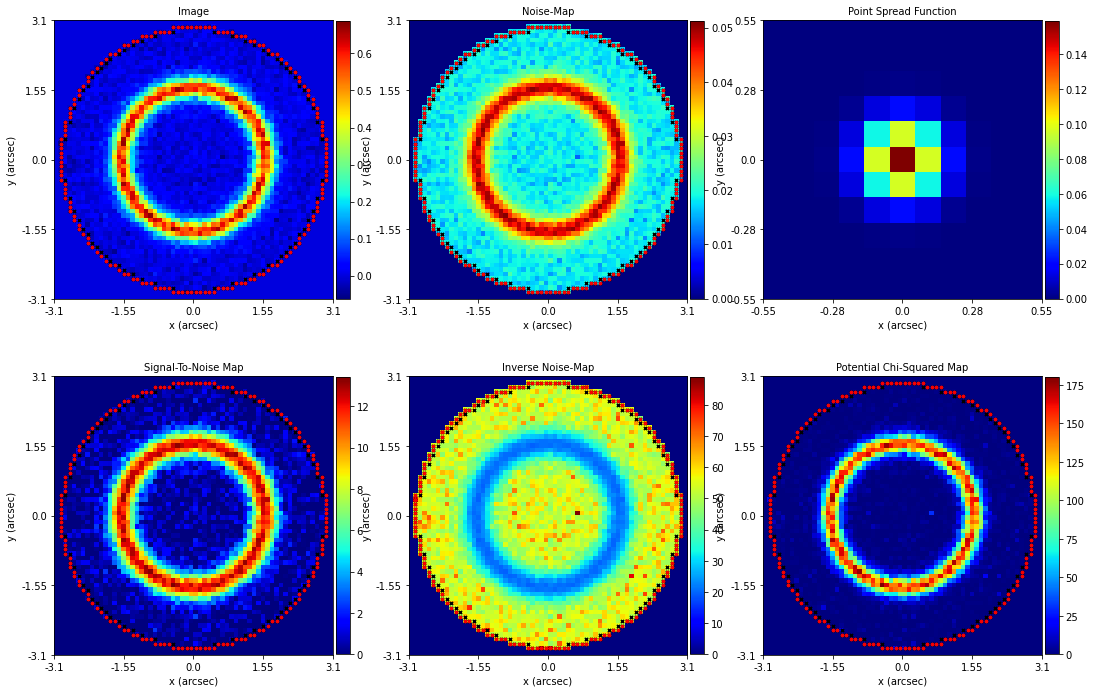

In [4]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Model__

To compose a lens model, we set up a `Galaxy` as a `Model`. Whereas previously, we manually specified the value of 
every parameter of a `Galaxy`'s light and mass profiles, when the galaxy is a `Model` only the class of each profile is 
passed. By creating the galaxy as `Model` we are telling **PyAutoLens** that the parameter's of its profiles are
to be fitted for via the non-linear search.

Lets model the lens galaxy with an spherical isothermal mass profile (which is what it was simulated with).

In [5]:
lens_galaxy_model = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.SphIsothermal)

Lets model the source galaxy with a spherical exponential light profile (again, what it was simulated with).

In [6]:
source_galaxy_model = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.SphExponential)

We now have multiple `Model` components, which we bring together into a final model via the `Collection` object.

Just like we are used to giving profiles descriptive names, like `bulge`, `disk` and `mass` we also name the galaxies 
that make up our model. Of course, its good practise for us to give them descriptive names and we'll use `lens` and
`source` to do this throughout the tutorials.

[It may seem odd that we define two `Collections`, with the `Collection` in the outer loop only having a `galaxies`
attribute. In future tutorials, we'll see that we can add additional model-components to a model other than just
galaxies, and the API below therefore makes it simple to extend the model to include these components.]

In [7]:
model = af.Collection(
    galaxies=af.Collection(lens=lens_galaxy_model, source=source_galaxy_model)
)

__Search__

We now create the non-linear search object which will fit the lens model, which as discussed above is the nested
sampling algorithm dynesty. We pass the `DynestyStatic` object the following:
   
 - A `path_prefix` which tells the search to output its results in the 
 folder `autolens_workspace/output/howtolens/chapter_2`. 
 
 - A `name`, which gives the search a name and means the full output path is 
   `autolens_workspace/output/howtolens/chapter_2/tutorial_1_non_linear_search`. 

 - Input parameters like `nlive` and `walks` which control how it samples parameter space. These are discussed
 in more detail in a later tutorial.

In [8]:
search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_2"),
    name="tutorial_1_non_linear_search",
    nlive=40,
    walks=5,
)

__Analysis__

The `AnalysisImaging` object defines how the non-linear search fits each lens model that it guesses (which consists of 
a set of parameters values for the light and mass profiles guessed by the search) to the `Imaging` dataset.

The fit is performed using the analysis class's `log_likelihood_function`, which in model-fitting is a commonly used 
term to describe a function that given a model and data, fits the model to the data to return a value of log 
likelihood, which the non-linear search uses the evaluate the goodness-of-fit.

This likelihood function is written in the **PyAutoLens** source code, but it essentially repeats the steps we discussed
in tutorial 8 of chapter 1 of **HowToLens**, where we computed a value of `log_likelihood` via a `FitImaging` object.

In [9]:
analysis = al.AnalysisImaging(dataset=imaging)

__Model-Fit__

We can now begin the model-fit by passing the model and analysis object to the search, which performs a non-linear
search to find which models fit the data with the highest likelihood.

Model fits using a non-linear search can take a long time to run. Whilst the fit in this tutorial should take just a  
few minutes, fitting more complex models can take upwards of hours! 

This is fine (lens modeling is simply a computationally expensive exercise), but it does make going through the 
tutorials problematic. This is especially true in Jupyter notebooks, as whilst the the non-linear search is running 
you won't be able to continue to the next notebook cell until the search has finished. 

For this reason, we recommend that you **do not** run each non-linear search in these tutorials via your Jupyter 
notebook, but instead run the corresponding Python script found in 
the `autolens_workspace/scripts/howtolens/chapter_2_lens_modeling` folder. 

This can be run either using the `python3` command on the command line, e.g.:

 `python3 scripts/howtolens/chapter_2_lens_modeling/tutoial_1_non_linear_search.py` 

Or via your IDE (if you are using one).

A non-linear search outputs all results to your hard-disk, in the `output` folder. Thus once it has run and is finished 
you can run its corresponding Jupyter notebook cell and it immediately load the result.

It is generally good practise to run lens modeling scripts outside of a notebook, given that the long run times make
notebook use cumbersome. For everything else though (loading results, inspection, plotting, interpretation) you should
use notebooks!

In [10]:
print(
    "Dynesty has begun running - checkout the autolens_workspace/output/"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result = search.fit(model=model, analysis=analysis)

print("Dynesty has finished run - you may now continue the notebook.")

INFO:root:tutorial_1_non_linear_search already completed, skipping non-linear search.


Dynesty has begun running - checkout the autolens_workspace/output/ folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


__Output Folder__

Now this is running you should checkout the `autolens_workspace/output` folder.

This is where the results of the search are written to your hard-disk (in the `tutorial_1_non_linear_search` folder). 
When its completed, images, results and information about the fit appear in this folder, meaning that you don't need 
to keep running Python code to see the result.

__Unique Identifier__

In the output folder, you will note that results are in a folder which is a collection of random characters. This acts 
as a `unique_identifier` of the model-fit, where this identifier is generated based on the model, search and dataset 
that are used in the fit.
 
An identical combination of model, search and dataset generates the same identifier, meaning that rerunning the
script will use the existing results to resume the model-fit. In contrast, if you change the model, search or dataset,
a new unique identifier will be generated, ensuring that the model-fit results are output into a separate folder. 

__On The Fly Outputs__

Even when the search is running, information about the highest likelihood model inferred by the search so-far 
is output to this folder on-the-fly. If you navigate to the folder: 

 `output/howtolens/chapter_1/tutorials_1_non_linear_search/unique_identifier` 
 
Even before the search has finished, you will see:

 1) The `images` folder, where images of the highest likelihood lens model are output on-the-fly. This includes the
 `FitImaging` subplot we plotted in the previous chapter, which therefore gives a real sense of 'how good' the model
 fit is.
 
 2) The `samples` folder, which contains a `.csv` table of every sample of the non-linear search as well as other 
 information. 
 
 3) The `model.info` file, which lists the lens model, its parameters and their priors (discussed in the next tutorial).
 
 4) The `model.results` file, which lists the highest likelihood lens model and the most probable lens model with 
 errors (this outputs on-the-fly).
 
 5) The `search.summary` file, which provides a summary of the non-linear search settings and statistics on how well
 it is performing.

__Result__

The `search.fit` method above returned a `result`, which contains lots of information about the lens model fit. We
will cover this in detail in a later tutorial.

One thing the result contains we'll use now is the `FitImaging` object that corresponds to the set of lens model
parameters that gae the maximum log likelihood solution. We plot this object as per usual to inspect how good our
fit was.

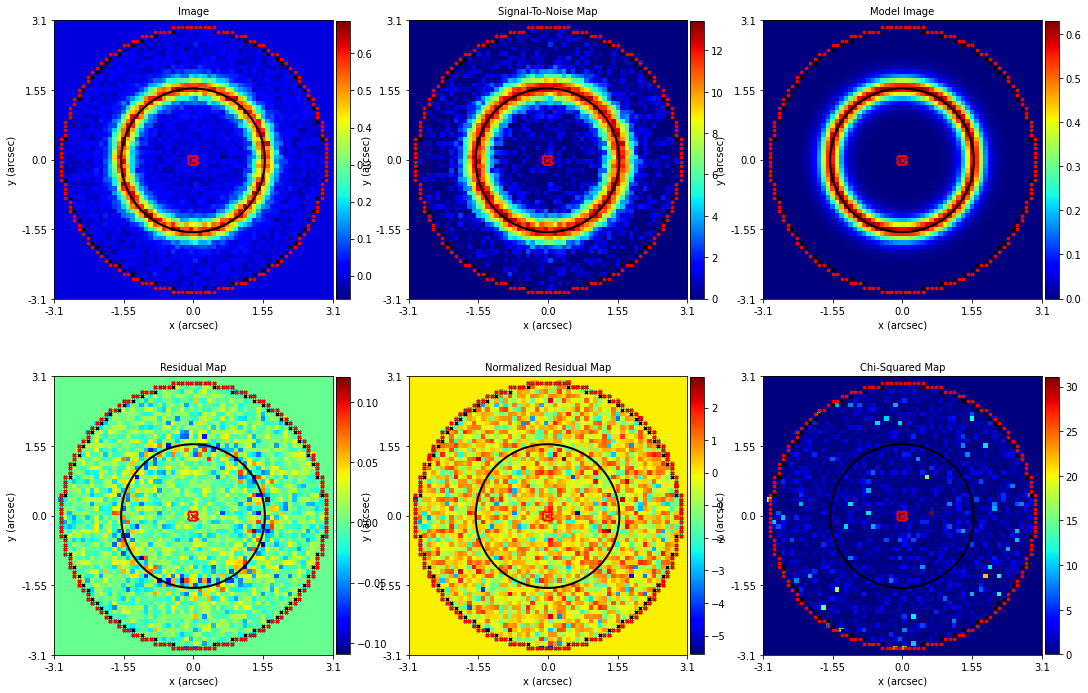

In [11]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

The fit looks good and we've therefore found a model close to the one I used to simulate the image with (you can 
confirm this yourself if you want, by comparing the inferred parameters to those found in the script
`autolens_workspace/notebooks/imaging/simulators/no_lens_light/mass_sis__source_sersic.py`).

__Wrap Up__

And with that, we are done. You have successfully modeled your first strong lens with **PyAutoLens**! Before moving 
onto the next tutorial, I want you to think about the following:

 1) a non-linear search is often said to search a `non-linear parameter-space`, why is the term parameter-space 
 used?

 2) Why is this parameter space 'non-linear'?

 3) Initially, the non-linear search randomly guesses the values of the parameters. However, how does it know what 
 a reasonable value for each parameter is? Why did it guess values of Einstein radius before 0.0 and 4.0, instead of
 between -10000000000000.0 and some other outlandish number? 